# Multiple Segmented Pendulums

We solve the Double Pendulum first, then the Triple Pendulum

## Double Pendulum

We will solve the double pendulum using the Lagrangian method. From the book, we procure:

$T = \frac{1}{2} (m_1+m_2)L_1^2 \dot{\phi_1}^2 + m_2 L_1 L_2 \dot{\phi_1}\dot{\phi_2} \cos{(\phi_1 - \phi_2)} + \frac{1}{2}m_2 L_2^2 \dot{\phi_2}^2 $

$U = (m_1 + m_2)g L_1 (1-\cos{\phi_1}) + m_2 g L_2 (1-\cos{\phi_2})$

$L = T - U$

Using the Euler-Lagrange equations, we get two, second-order, ordinary, coupled differential equations. I solve these for $\ddot\phi_1, \ddot\phi_2$ in my Mathematica notebook DoublePendCalc.nb using matrices, and solve for it again in my TriplePendCalc.nb from cartesian coordinates using Mathematica's "Solve" function. The solution to these are implemented in the DoublePendulum class for y_dot[1] and y_dot[3].

In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

# Import the widgets we will use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display
from time import sleep

In [2]:
def sin(x):
    return np.sin(x)
def cos(x):
    return np.cos(x)

class DoublePendulum():
    """
    DoublePendulum class implements the parameters and differential equation for 
    a double pendulum using the notation above.
     
    Parameters
    ----------
    L1 : float
         first segment's length 
    L2 : float
        second segment's length
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    """
    def __init__(self, L1=1., L2=1, m1=1., m2=1., g=1.):
        self.L1=L1
        self.L2=L2
        self.m1=m1
        self.m2=m2
        self.g=g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi_1(t)  = theta1
            y[1] = dphi_1/dt = z1
            y[2] = phi_2(t)  = theta2
            y[3] = dphi_2/dt = z2
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dphi_1/dt      = z1
            y_dot[1] = d^2 phi_1/dt^2 = z1_dot
            y_dot[2] = dphi_2/dt      = z2
            y_dot[3] = d^2 phi_2/dt^2 = z2_dot     
        
        """
        y_dot = [0.,0.,0.,0.]
        theta1 = y[0]
        z1 = y[1]
        theta2 = y[2]
        z2 = y[3]
        
        g = self.g
        L1 = self.L1
        L2 = self.L2
        m1 = self.m1
        m2 = self.m2
        
        c = cos(theta1-theta2)
        s = sin(theta1-theta2)
        denom = (m1 + m2*(s**2))
        
        # Do dphi_1/dt and dphi_2/dt first:
        y_dot[0] = z1
        y_dot[2] = z2
        
        # Now do d^2 phi_1/dt^2 
        y_dot[1]= (-g*(m1 + m2)*sin(theta1) - m2*(L2*(z2**2)+L1*(z1**2)*c)*s \
            + g*m2*c*sin(theta2))/(L1*denom)
                    
            
        # Finally do d^2 phi_2/dt^2 
        y_dot[3]= s*(g*(m1+m2)*cos(theta1)+L1*(m1+m2)*(z1**2)+L2*m2*c*(z2**2)) \
            /(L2*denom)
        
        return y_dot
    
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

class TriplePendulum():
    """
    TriplePendulum class implements the parameters and differential equation for 
    a triple pendulum using the notation above.
     
    Parameters
    ----------
    L1 : float
         first segment's length 
    L2 : float
        second segment's length
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    """
    def __init__(self, LVec=[1.,1.,1.], mVec=[1.,1.,1.], g=1.):
        self.LVec = LVec
        self.mVec = mVec
        self.g=g
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi_1(t)  = th1
            y[1] = dphi_1/dt = z1
            y[2] = phi_2(t)  = th2
            y[3] = dphi_2/dt = z2
            y[4] = phi_3(t)  = th3
            y[5] = dphi_3/dt = z3
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dphi_1/dt      = z1
            y_dot[1] = d^2 phi_1/dt^2 = z1_dot
            y_dot[2] = dphi_2/dt      = z2
            y_dot[3] = d^2 phi_2/dt^2 = z2_dot 
            y_dot[4] = dphi_3/dt      = z3
            y_dot[5] = d^2 phi_3/dt^2 = z3_dot             
        
        """
        y_dot = [0. for i in range(6)]
        th1, th2, th3 = y[0], y[2], y[4]
        z1, z2, z3 = y[1], y[3], y[5]
        z1sq, z2sq, z3sq = z1**2, z2**2, z3**2

        g = self.g
        L1, L2, L3 = self.LVec
        m1, m2, m3 = self.mVec
        
        denom = m2*(2*m1+m2)+(m1+m2)*m3-m2*(m2+m3)*cos(2*(th1-th2)) \
            -m1*m3*cos(2*(th2-th3))
        
        # Do dphi_1/dt and dphi_2/dt first:
        y_dot[0] = z1
        y_dot[2] = z2
        y_dot[4] = z3
        
        # Now do d^2 phi_1/dt^2 
        y_dot[1]= -(g*(m2*(m2+m3)+m1*(2*m2+m3)-m1*m3*cos(2*(th2-th3))) \
            *sin(th1)+g*m2*(m2+m3)*sin(th1-2*th2)+2*m2*sin(th1-th2) \
            *((m2+m3)*(L1*cos(th1-th2)*z1sq+L2*z2sq)+L3*m3*cos(th2-th3) \
            *z3sq))/(L1*denom)                    
            
        # Next do d^2 phi_2/dt^2 
        y_dot[3]= (g*cos(th1)*((2*m2*(m1+m2)+(m1+2*m2)*m3)*sin(th1-th2) \
                    -m1*m3*sin(th1+th2-2*th3))
            +L1*((2*m2*(m1+m2)+(m1+2*m2)*m3)*sin(th1-th2) \
                    -m1*m3*sin(th1+th2-2*th3))*z1sq \
            +L2*(m2*(m2+m3)*sin(2*(th1-th2))-m1*m3*sin(2*(th2-th3)))*z2sq \
            +2*L3*m3*(m2*cos(th1-th3)*sin(th1-th2)-m1*sin(th2-th3))*z3sq) \
            /(L2*denom)
        
        # Finally do d^2 phi_3/dt^2
        y_dot[5]= (2*m1*sin(th2-th3)*((m2+m3)*(cos(th1-th2)*(g*cos(th1)+L1*z1sq)+L2*z2sq) \
                +L3*m3*cos(th2-th3)*z3sq))/(L3*denom)
         
        return y_dot
    
    
    def solve_ode(self, t_pts, y_0, abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = y_0 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y                      
                    
                    


In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [10]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
deltaphi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

 

# Common pendulum parameters
m_1 = 1.
m_2 = 100.
L_1 = 1.
L_2 = 1.
g_ = 1.


# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L_1, L2=L_2, m1=m_1, m2=m_2, g=g_)

In [11]:
def Plot_DoublePend(obj=dp1, phi1_0=np.pi/2., phi1_dot_0=0., \
                    phi2_0=0., phi2_dot_0=0., dPhi=0.0001, \
                    t_reg_end=100., t_diff_end=200):

    # Plotting time (generate the full time then use slices)
    t_start = 0.
    t_end = np.array([t_reg_end, t_diff_end]).max()
    delta_t = 0.01
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)
    
    phi1, phi1_dot, phi2, phi2_dot = obj.solve_ode(t_pts, phi1_0, phi1_dot_0,\
                                                   phi2_0, phi2_dot_0)
    phi1p, phi1_dotp, phi2p, phi2_dotp = obj.solve_ode(t_pts, phi1_0+dPhi, \
                                        phi1_dot_0, phi2_0+dPhi, phi2_dot_0)
    
    deltaPhi1 = np.abs(phi1-phi1p)
    deltaPhi2 = np.abs(phi2-phi2p)
    
    # Print the length of the arrays, in case everything breaks
    #print(t_pts.shape, phi1.shape, phi2.shape)
    #print(phi1_dot.shape, phi2_dot.shape)
    
    # start the plot!
    fig = plt.figure(figsize=(15,5))
    
    overall_title = 'Double Pendulum:  ' + \
                    rf' $m_1 = {obj.m1:.2f},$' + \
                    rf' $m_2 = {obj.m2:.2f},$' + \
                    rf' $L_1 = {obj.L1:.2f},$' + \
                    rf' $L_2 = {obj.L2:.2f},$' + \
                    rf' $g = {obj.g:.2f},$' + '\n' +  \
                    rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                    rf' $\dot\phi_1(0) = {phi1_dot_0:.2f},$' + \
                    rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                    rf' $\dot\phi_2(0) = {phi2_dot_0:.2f},$' +'\n'
    fig.suptitle(overall_title, va='baseline')
    
    # first plot: plot from t=0 to t=10   
    ax_a = fig.add_subplot(1,3,1)                  
    
    start, stop = start_stop_indices(t_pts, t_start, t_reg_end)    
    plot_y_vs_x(t_pts[start : stop], phi1[start : stop],  
                color='blue',
                label=r"$\phi_1$",
                ax=ax_a)  
    plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
                axis_labels=phi_vs_time_labels, 
                color='red',
                label=r"$\phi_2$", 
                title=rf'Position: $0 \leq t \leq (T_1={t_reg_end:.1f})$', 
                ax=ax_a)  
    
    # second plot: state space plot from t=30 to t=50   
    ax_b = fig.add_subplot(1,3,2)                  
    
    start, stop = start_stop_indices(t_pts, 0., t_reg_end)    
    plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop],  
                color='blue',
                label=r"$\phi_1$",  
                ax=ax_b)    
    plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
                axis_labels=state_space_labels, 
                color='red',
                label=r"$\phi_2$", 
                title=rf'State Space: $0 \leq t \leq (T_1={t_reg_end:.1f})$', 
                ax=ax_b)   
    
    # third plot: delta phi plot
    ax_a = fig.add_subplot(1,3, 3)                  
    
    start, stop = start_stop_indices(t_pts, 0., t_diff_end)    
    plot_y_vs_x(t_pts[start : stop], deltaPhi1[start : stop],  
                color='blue',
                label=rf'$\Delta\Phi_1$', 
                semilogy=True,
                ax=ax_a)
    plot_y_vs_x(t_pts[start : stop], deltaPhi2[start : stop], 
                axis_labels=deltaphi_vs_time_labels, 
                color='red',
                label=rf'$\Delta\Phi_2$', 
                semilogy=True,
                title=rf'Difference in IC: $\Delta\phi={dPhi:.4f},'+\
                    rf' 0 \leq t \leq (T_2={t_diff_end:.1f})$', 
                ax=ax_a) 
    
    fig.tight_layout()
    fig.savefig('DoublePend.png', bbox_inches='tight')  # always bbox_inches='tight'
    
    return fig
    
# Widgets for the pendulum parameters (all use FloatSlider, so made function)
def float_widget(value, min, max, step, description, format):
    """Makes a FloatSlider with the passed parameters and continuous_update
       set to False."""
    slider_border = Layout(border='solid 1.0px')
    return FloatSlider(value=value,min=min,max=max,step=step,disabled=False,
                       description=description,continuous_update=False,
                       orientation='horizontal',layout=slider_border,
                       readout=True,readout_format=format)

"""
#To plot manually, use this. Don't forget to comment out 'return fig'.
#Otherwise, you get 2 plots
# Choose ICs for the plot. Note: I am adding dPhi
phi1_0     = np.pi/2
phi1_dot_0 = 0.
phi2_0     = 0.
phi2_dot_0 = 0.
dPhi       = 0.0001
t_reg_end  = 100.
t_diff_end = 200.
Plot_DoublePend(obj=dp1, phi1_0=phi1_0, phi1_dot_0=phi1_dot_0, phi2_0=phi2_0, \
    phi2_dot_0=phi2_dot_0, dPhi=dPhi, t_reg_end=t_reg_end, t_diff_end=t_diff_end)
"""

# Create the sliders we are interested in
phi1_0_w = float_widget(value=np.pi/2., min=-np.pi, max=np.pi, step=0.05,
                         description=r'$\phi_1(0)$:', format='.2f')
phi1_dot_0_w = float_widget(value=0., min=-0.5, max=0.5, step=0.01,
                         description=r'$\dot\phi_1(0)$:', format='.2f')
phi2_0_w = float_widget(value=0., min=-np.pi, max=np.pi, step=0.05,
                         description=r'$\phi_2(0)$:', format='.2f')
phi2_dot_0_w = float_widget(value=0., min=-0.5, max=0.5, step=0.01,
                         description=r'$\dot\phi_2(0)$:', format='.2f')
dPhi_w = float_widget(value=0.0001, min=0., max=0.1, step=0.001,
                         description=r'$\Delta\phi$:', format='.4f')
t_reg_end_w = float_widget(value=100., min=0., max=500., step=10,
                         description=r'$T_{end, 1}$:', format='.0f')
t_diff_end_w = float_widget(value=200., min=0., max=800., step=100,
                         description=r'$T_{end, 2}$ for Difference:', format='.0f')

# Set up the interactive_output widget 
plot_out = widgets.interactive_output(Plot_DoublePend,
                    dict( 
                    phi1_0 = phi1_0_w,
                    phi1_dot_0 = phi1_dot_0_w,
                    phi2_0 = phi2_0_w,
                    phi2_dot_0 = phi2_dot_0_w,
                    dPhi=dPhi_w, 
                    t_reg_end=t_reg_end_w,
                    t_diff_end=t_diff_end_w
                    )
                )
# We want two 
hbox1 = HBox([phi1_0_w, phi2_0_w, phi1_dot_0_w, phi2_dot_0_w])
hbox2 = HBox([dPhi_w, t_reg_end_w, t_diff_end_w])

tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = VBox([hbox1, hbox2], layout=Layout(min_height=tab_height))
vbox = VBox([tab0, plot_out])

display(vbox)

### Why Chaotic for Large Angles?
As we can see in the rightmost plot, for the initial conditions provided, the absolute difference between nearly identical initial conditions (ICs) increases linearly on a semi-log plot until it reaches $10^0$, which is of order $2\pi$. With energetic enough ICs, this can climb still higher.

### Why Periodic for Small Angles?
Using the initial conditions provided, move the $\phi_1$ slider down to near zero (around 0.1 should do). We can see in the position plot a very periodic behavior. In the State space plot, the angles trace a complex pattern repeatedly. The rightmost plot should appear linear, so different ICs do not diverge.

## Triple Pendulum

We will solve the triple pendulum using the Lagrangian method. We start with the cartesian form of T:

$T_{cart} = \frac{1}{2}m_1(\dot x_1^2 + \dot y_1^2) + \frac{1}{2}m_2((\dot x_1+\dot x_2)^2 + (\dot y_1+\dot y_2)^2)+ \frac{1}{2}m_3((\dot x_1+\dot x_2+\dot x_3)^2 + (\dot y_1+\dot y_2+\dot y_3)^2) $

Using Mathematica to convert to polar for us, we recieve:

$
T = \frac{1}{2}(m_1+m_2)L_1^2 \dot\phi_1^2 + \frac{1}{2}m_2 L_2^2 \dot\phi_2^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1-\phi_2) + \frac{1}{2}m_3\left[ (\sum_{i=1}^3 L_i \dot\phi_i\cos\phi_i)^2 + (\sum_{i=1}^3 L_i \dot\phi_i\sin\phi_i)^2 \right]
$

Which we notice to be the double pendulum T plus additional terms involving the velocity of the third bob. From here, it would be fairly easy to extrapolate to the n-pendulum T equation, but we will not waste time with this!

The potential energy can easily be written down directly in polar form:

$U = m_1 g L_1 (1-\cos{\phi_1}) + m_2 g \left[L_1(1-\cos{\phi_1})+L_2 (1-\cos{\phi_2})\right]+ m_3 g \left[L_1(1-\cos{\phi_1})+L_2 (1-\cos{\phi_2})+L_3 (1-\cos{\phi_3})\right]$

We can therefore construct the Lagrangian

$L = T - U$

Using the Euler-Lagrange equations, we get three second order, ordinary, coupled differential equations. I solve these for $\ddot\phi_1, \ddot\phi_2, \ddot\phi_3$ in my Mathematica notebook TriplePendCalc.nb from cartesian coordinates using Mathematica's "Solve" function. The solution to these are implemented in the TriplePendulum class far above for y_dot[1], y_dot[3], and y_dot[5].

In [6]:
# Common pendulum parameters. Here we use vectors to simplify notation.
# As you expect, m1, m2, m3 = m_vec; L1, L2, L3 = L_vec
m_vec=[1,1,1]
L_vec=[1,1,1]
g_val = 1.


# Instantiate a pendulum 
tp1 = TriplePendulum(LVec=L_vec, mVec=m_vec, g=g_val)

In [17]:
def Plot_TriplePend(obj=tp1,
                    phi1_0=np.pi/2., phi1_dot_0=0.,
                    phi2_0=0., phi2_dot_0=0.,
                    phi3_0=0., phi3_dot_0=0.,
                    dPhi=0.0001,
                    t_reg_end=100., t_diff_end=200):
    
    # Create IC list
    """
        y_0[0] = phi_1(0)
        y_0[1] = dphi_1/dt(0) = z1
        y_0[2] = phi_2(t)(0)
        y_0[3] = dphi_2/dt(0)
        y_0[4] = phi_3(t)(0)
        y_0[5] = dphi_3/dt(0)
    """
    y_0 = phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, phi3_0, phi3_dot_0
    
    # Plotting time (generate the full time then use slices)
    t_start = 0.
    t_end = np.array([t_reg_end, t_diff_end]).max()
    delta_t = 0.1
    t_pts = np.arange(t_start, t_end+delta_t, delta_t) 
    
    # Initialize the ICs for the slightly different solution
    dy_0 = [y_0[i] for i in range(6)]
    dy_0[0] += dPhi
    dy_0[2] += dPhi
    dy_0[4] += dPhi
    
    # Solve the Diff Eqs for both cases
    phi1, phi1_dot, phi2, phi2_dot, phi3, phi3_dot = tp1.solve_ode(t_pts, y_0)
    phi1p, phi1_dotp, phi2p, phi2_dotp, phi3p, phi3_dotp = tp1.solve_ode(t_pts, dy_0)
    # Calculate deltaPhi for the third plot
    deltaPhi1 = np.abs(phi1-phi1p)
    deltaPhi2 = np.abs(phi2-phi2p)
    deltaPhi3 = np.abs(phi3-phi3p)
    
    # Start the plot!
    fig = plt.figure(figsize=(15,5))
    
    overall_title = 'Double Pendulum:  ' + \
                    rf' $m_1 = {obj.mVec[0]:.2f},$' + \
                    rf' $m_2 = {obj.mVec[1]:.2f},$' + \
                    rf' $m_3 = {obj.mVec[2]:.2f},$' + \
                    rf' $L_1 = {obj.LVec[0]:.2f},$' + \
                    rf' $L_2 = {obj.LVec[1]:.2f},$' + \
                    rf' $L_3 = {obj.LVec[2]:.2f},$' + \
                    rf' $g = {obj.g:.2f},$' + '\n' +  \
                    rf' $\phi_1(0) = {y_0[0]:.2f},$' + \
                    rf' $\dot\phi_1(0) = {y_0[1]:.2f},$' + \
                    rf' $\phi_2(0) = {y_0[2]:.2f},$' + \
                    rf' $\dot\phi_2(0) = {y_0[3]:.2f},$' + \
                    rf' $\phi_3(0) = {y_0[4]:.2f},$' + \
                    rf' $\dot\phi_3(0) = {y_0[5]:.2f},$' +'\n'
    fig.suptitle(overall_title, va='baseline')
    
    # First plot: phi vs. time for the three phis
    ax_a = fig.add_subplot(1,3,1)                  
    start, stop = start_stop_indices(t_pts, t_start, t_reg_end)    
    plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
                color='blue',
                label=r"$\phi_1$",
                ax=ax_a)  
    plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
                color='red',
                label=r"$\phi_2$",  
                ax=ax_a)  
    plot_y_vs_x(t_pts[start : stop], phi3[start : stop], 
                axis_labels=phi_vs_time_labels, 
                color='green',
                label=r"$\phi_3$", 
                title=rf'Position: $0 \leq t \leq {t_reg_end:.1f}$', 
                ax=ax_a)
    
    # Second plot: state space plot for all three phis   
    ax_b = fig.add_subplot(1,3,2)                  
    
    start, stop = start_stop_indices(t_pts, 0., t_reg_end)    
    plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop],  
                color='blue',
                label=r"$\phi_1$",  
                ax=ax_b)    
    plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop],  
                color='red',
                label=r"$\phi_2$", 
                ax=ax_b)
    plot_y_vs_x(phi2[start : stop], phi3_dot[start : stop], 
                axis_labels=state_space_labels, 
                color='green',
                label=r"$\phi_3$", 
                title=rf'State Space: $0 \leq t \leq {t_reg_end:.1f}$', 
                ax=ax_b)
    
    # third plot: delta phi plot for each phi
    ax_a = fig.add_subplot(1,3, 3)                  
    
    start, stop = start_stop_indices(t_pts, 0., t_diff_end)    
    plot_y_vs_x(t_pts[start : stop], deltaPhi1[start : stop],  
                color='blue',
                label=rf'$\Delta\Phi_1$', 
                semilogy=True,
                ax=ax_a)
    plot_y_vs_x(t_pts[start : stop], deltaPhi2[start : stop],  
                color='red',
                label=rf'$\Delta\Phi_2$', 
                semilogy=True,
                ax=ax_a) 
    plot_y_vs_x(t_pts[start : stop], deltaPhi3[start : stop], 
                axis_labels=deltaphi_vs_time_labels, 
                color='green',
                label=rf'$\Delta\Phi_3$', 
                semilogy=True,
                title=rf'Difference in IC: $\Delta\phi={dPhi:.3f},'+\
                    rf' 0 \leq t \leq {t_diff_end:.1f}$', 
                ax=ax_a)
    
    fig.tight_layout()
    fig.savefig('TriplePend.png', bbox_inches='tight')  # always bbox_inches='tight'

# Create the sliders we are interested in
phi1_0_w = float_widget(value=np.pi/2., min=-np.pi, max=np.pi, step=0.05,
                         description=r'$\phi_1(0)$:', format='.2f')
phi1_dot_0_w = float_widget(value=0., min=-0.5, max=0.5, step=0.01,
                         description=r'$\dot\phi_1(0)$:', format='.2f')
phi2_0_w = float_widget(value=0., min=-np.pi, max=np.pi, step=0.05,
                         description=r'$\phi_2(0)$:', format='.2f')
phi2_dot_0_w = float_widget(value=0., min=-0.5, max=0.5, step=0.01,
                         description=r'$\dot\phi_2(0)$:', format='.2f')
phi3_0_w = float_widget(value=0., min=-np.pi, max=np.pi, step=0.05,
                         description=r'$\phi_3(0)$:', format='.2f')
phi3_dot_0_w = float_widget(value=0., min=-0.5, max=0.5, step=0.01,
                         description=r'$\dot\phi_3(0)$:', format='.2f')
dPhi_w = float_widget(value=0.001, min=0., max=0.1, step=0.001,
                         description=r'$\Delta\phi$:', format='.4f')
t_reg_end_w = float_widget(value=100., min=0., max=500., step=10,
                         description=r'$T_{end, 1}$:', format='.0f')
t_diff_end_w = float_widget(value=200., min=0., max=800., step=100,
                         description=r'$T_{end, 2}$:', format='.0f')

# Set up the interactive_output widget 
plot_out = widgets.interactive_output(Plot_TriplePend,
                    dict( 
                    phi1_0 = phi1_0_w,
                    phi1_dot_0 = phi1_dot_0_w,
                    phi2_0 = phi2_0_w,
                    phi2_dot_0 = phi2_dot_0_w,
                    phi3_0 = phi3_0_w,
                    phi3_dot_0 = phi3_dot_0_w,
                    dPhi=dPhi_w, 
                    t_reg_end=t_reg_end_w,
                    t_diff_end=t_diff_end_w
                    )
                )
# We want two 
hbox1 = HBox([phi1_0_w, phi2_0_w, phi3_0_w])
hbox2 = HBox([phi1_dot_0_w, phi2_dot_0_w, phi3_dot_0_w])
hbox3 = HBox([dPhi_w, t_reg_end_w, t_diff_end_w])

tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = VBox([hbox1, hbox2, hbox3], layout=Layout(min_height=tab_height))
vbox = VBox([tab0, plot_out])

display(vbox)

These plots are so cool!

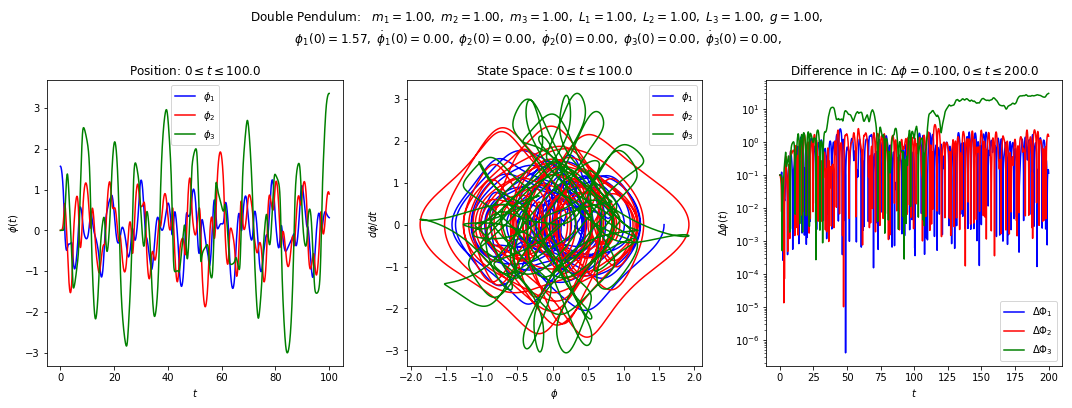

In [15]:
fig1 = Plot_TriplePend(obj=tp1,
                    phi1_0=np.pi/2., phi1_dot_0=0.,
                    phi2_0=0., phi2_dot_0=0.,
                    phi3_0=0., phi3_dot_0=0.,
                    dPhi=0.001,
                    t_reg_end=100., t_diff_end=200)